# Predicting Temperature Time Series with LSTM Using PyTorch

### Introduction
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) that is commonly used for sequence modeling, particularly for processing time-series data. Unlike traditional RNNs, LSTMs have a memory cell that allows them to selectively remember or forget information over time, which makes them particularly useful for long-term dependencies.

In this tutorial, we'll use Pytorch to build an LSTM model that can predict a time-series based on previous data. We'll use numpy and pandas to preprocess the data.

## Step 1: Import Libraries
We'll start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

### Step 2: Load Data
For this tutorial, we'll use a sample dataset that contains temperature readings for a single sensor over time. We'll load the dataset into a pandas DataFrame and preprocess it so that it can be fed into our LSTM model.

In [2]:
# Load data into a pandas DataFrame
df = pd.read_csv('../data/temperature.csv')

# Convert the 'datetime' column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'datetime' column as the index
df.set_index('Date', inplace=True)

# Resample the data to hourly intervals and fill missing values with the previous value
df = df.resample('H').ffill()

# Normalize the data
df = (df - df.mean()) / df.std()

# Convert the DataFrame to a numpy array
data = df.values

### Step 3: Split Data

Next, we'll split the data into training and testing sets. We'll use the first 70% of the data for training and the remaining 30% for testing.

In [3]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.7)
train_data, test_data = data[:train_size], data[train_size:]

### Step 4: Create Data Sequences
Before we can train our LSTM model, we need to create sequences of data that the model can learn from. We'll create sequences of length 24 (one day), and we'll use a sliding window approach to create overlapping sequences.

In [4]:
# Function to create sequences of data
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for training and testing data
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

### Step 5: Create LSTM Model
Now, we'll create our LSTM model using Pytorch. Our model will have one LSTM layer with 32 hidden units and one fully connected output layer.

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In the ``__init__`` method, we define an LSTM layer with hidden_size hidden units and a fully connected output layer with output_size output units. In the forward method, we pass the input `x` through the LSTM layer, take the output of the last time step, and pass it through the fully connected output layer.

### Step 6: Instantiate Model and Define Loss Function and Optimizer
Now, we'll instantiate our LSTM model, define our loss function (mean squared error), and define our optimizer (Adam).

In [6]:
# Instantiate the model
input_size = X_train.shape[2]
hidden_size = 32
output_size = 1
model = LSTM(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Step 7: Train the Model
Next, we'll train our LSTM model on the training data. We'll use a batch size of 32 and train for 50 epochs.

In [7]:
# Convert numpy arrays to Pytorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Define the batch size and number of epochs
batch_size = 32
num_epochs = 25

# Train the model
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]

    # Loop over batches
    for i in range(0, X_train.shape[0], batch_size):
        # Get batch
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/25], Loss: 0.0000
Epoch [2/25], Loss: 0.0001
Epoch [3/25], Loss: 0.0000
Epoch [4/25], Loss: 0.0005
Epoch [5/25], Loss: 0.0004
Epoch [6/25], Loss: 0.0000
Epoch [7/25], Loss: 0.0001
Epoch [8/25], Loss: 0.0005
Epoch [9/25], Loss: 0.0000
Epoch [10/25], Loss: 0.0000
Epoch [11/25], Loss: 0.0001
Epoch [12/25], Loss: 0.0003
Epoch [13/25], Loss: 0.0000
Epoch [14/25], Loss: 0.0000
Epoch [15/25], Loss: 0.0001
Epoch [16/25], Loss: 0.0000
Epoch [17/25], Loss: 0.0000
Epoch [18/25], Loss: 0.0005
Epoch [19/25], Loss: 0.4313
Epoch [20/25], Loss: 0.0000
Epoch [21/25], Loss: 0.0003
Epoch [22/25], Loss: 0.0002
Epoch [23/25], Loss: 1.2080
Epoch [24/25], Loss: 0.0001
Epoch [25/25], Loss: 0.0000


### Step 8: Evaluate the Model
Finally, we'll evaluate our LSTM model on the testing data.

In [8]:
# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate the test loss
test_loss = criterion(y_pred, y_test)
print('Test Loss: {:.4f}'.format(test_loss.item()))

Test Loss: 0.0168


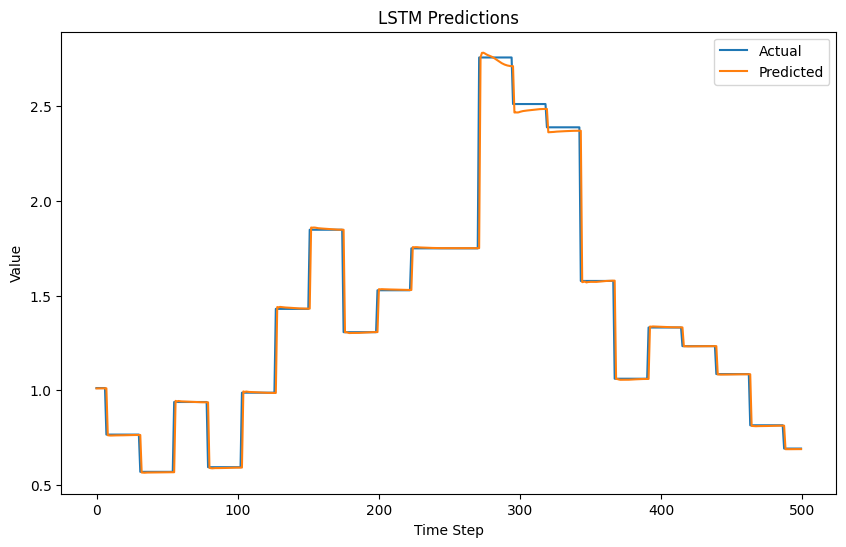

In [9]:
import matplotlib.pyplot as plt

# Convert Pytorch tensors to numpy arrays
y_test = y_test.numpy()
y_pred = y_pred.numpy()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()